# Flight Price Prediction

I will be training regression models to predict flight prices based on features such as the airline, the departure time, the arrival time, departure location, arrival location, etc.

Dataset: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import math

plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

### Data Cleaning

In [245]:
df_bus = pd.read_csv('business.csv')
df_eco = pd.read_csv('economy.csv')

In [246]:
df_bus.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612"
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220"
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450"
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690"


In [247]:
df_eco.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11/2/2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11/2/2022,SpiceJet,SG,8157,6:20,Delhi,02h 20m,non-stop,8:40,Mumbai,"5,953"
2,11/2/2022,AirAsia,I5,764,4:25,Delhi,02h 10m,non-stop,6:35,Mumbai,"5,956"
3,11/2/2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11/2/2022,Vistara,UK,963,8:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"


In [248]:
# add a column for their class type

df_bus['class'] = 'business'
df_eco['class'] = 'economy'

In [249]:
def data_clean(df):
    """
    This cleans the data to have columns that I desire.
    Step by step process will be in another notebook.
    """
    # get the date into the right format
    df['date'] = df['date'].str.replace('-', '/')
    df['day'] = df['date'].astype(str).str[0:2]
    df['day'] = df['day'].str.replace('/', '')
    df['month'] = df['date'].str.extract('/([^/]+)/')
    df['year'] = df['date'].astype(str).str[-4:]
    df['date'] = (df['month'] + '/' + df['day'] + '/' + df['year'])
    df['date'] = pd.to_datetime(df['date'])

    # normalized the naming convention for all the stops
    df['stop'] = df['stop'].str.extract('([^/]+)-')
    df['stop'] = df['stop'].str.replace('1', 'one-stop')
    df['stop'] = df['stop'].str.replace('2+', 'two-or-more-stops')
    df['stop'] = df['stop'].str.replace('non', 'no-stops')

    # combined code and number to get flight number
    df['flight_no'] = (df['ch_code'] + '-' + df['num_code'].astype(str))

    # got the hours for departure and arrival times
    df['dep_hour'] = df['dep_time'].str.extract('([^/]+):').astype(int)
    df['arr_hour'] = df['arr_time'].str.extract('([^/]+):').astype(int)

    # categorized the departure and arrival times based on hour
    df['dep_timeframe'] = pd.cut(df['dep_hour'],
                             bins = [0,4,8,12,16,20,23],
                             labels = ['Late Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night'],
                             include_lowest = True)
    df['arr_timeframe'] = pd.cut(df['arr_hour'],
                             bins = [0,4,8,12,16,20,23],
                             labels = ['Late Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night'],
                             include_lowest = True)

    # cleaned up the flight duration so that it is a decimal format istead of hours and minutes
    df['hours taken'] = df['time_taken'].str.extract('([^/]+) ')
    df['hours taken'] = df['hours taken'].str.extract('(\d+)', expand=False)
    df['hours taken'] = df['hours taken'].astype(float)
    df['minutes taken'] = df['time_taken'].astype(str).str[-3:]
    df['minutes taken'] = ((df['minutes taken'].str.extract('(\d+)', expand=False).astype(float))/60).round(2)
    df['duration'] = df['hours taken'] + df['minutes taken']

    # removed the , from the prices
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].astype(int)

    # the columns that I decided to keep for now
    df = df[['date','airline','flight_no','from','dep_timeframe','stop','arr_timeframe','to','duration','price', 'class']]

    return df

In [250]:
df_bus = data_clean(df_bus)

In [251]:
df_eco = data_clean(df_eco)

In [252]:
df_bus

,date,airline,flight_no,from,dep_timeframe,stop,arr_timeframe,to,duration,price,class
0,2022-02-11,Air India,AI-868,Delhi,Evening,no-stops,Evening,Mumbai,2.0000,25612,business
1,2022-02-11,Air India,AI-624,Delhi,Evening,no-stops,Night,Mumbai,2.2500,25612,business
2,2022-02-11,Air India,AI-531,Delhi,Evening,one-stop,Evening,Mumbai,24.7500,42220,business
3,2022-02-11,Air India,AI-839,Delhi,Night,one-stop,Night,Mumbai,26.5000,44450,business
4,2022-02-11,Air India,AI-544,Delhi,Evening,one-stop,Night,Mumbai,6.6700,46690,business
...,...,...,...,...,...,...,...,...,...,...,...
93482,2022-03-31,Vistara,UK-822,Chennai,Morning,one-stop,Evening,Hyderabad,10.0800,69265,business
93483,2022-03-31,Vistara,UK-826,Chennai,Morning,one-stop,Night,Hyderabad,10.4200,77105,business
93484,2022-03-31,Vistara,UK-832,Chennai,Early Morning,one-stop,Evening,Hyderabad,13.8300,79099,business
93485,2022-03-31,Vistara,UK-828,Chennai,Early Morning,one-stop,Evening,Hyderabad,10.0000,81585,business


In [253]:
df_eco

,date,airline,flight_no,from,dep_timeframe,stop,arr_timeframe,to,duration,price,class
0,2022-02-11,SpiceJet,SG-8709,Delhi,Evening,no-stops,Night,Mumbai,2.1700,5953,economy
1,2022-02-11,SpiceJet,SG-8157,Delhi,Early Morning,no-stops,Early Morning,Mumbai,2.3300,5953,economy
2,2022-02-11,AirAsia,I5-764,Delhi,Late Night,no-stops,Early Morning,Mumbai,2.1700,5956,economy
3,2022-02-11,Vistara,UK-995,Delhi,Morning,no-stops,Morning,Mumbai,2.2500,5955,economy
4,2022-02-11,Vistara,UK-963,Delhi,Early Morning,no-stops,Morning,Mumbai,2.3300,5955,economy
...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,UK-832,Chennai,Early Morning,one-stop,Evening,Hyderabad,13.8300,7697,economy
206770,2022-03-31,Vistara,UK-832,Chennai,Early Morning,one-stop,Evening,Hyderabad,13.8300,7709,economy
206771,2022-03-31,Vistara,UK-826,Chennai,Morning,one-stop,Morning,Hyderabad,20.5800,8640,economy
206772,2022-03-31,Vistara,UK-822,Chennai,Morning,one-stop,Morning,Hyderabad,23.3300,8640,economy


In [254]:
df = pd.concat([df_bus, df_eco])

In [255]:
df

,date,airline,flight_no,from,dep_timeframe,stop,arr_timeframe,to,duration,price,class
0,2022-02-11,Air India,AI-868,Delhi,Evening,no-stops,Evening,Mumbai,2.0000,25612,business
1,2022-02-11,Air India,AI-624,Delhi,Evening,no-stops,Night,Mumbai,2.2500,25612,business
2,2022-02-11,Air India,AI-531,Delhi,Evening,one-stop,Evening,Mumbai,24.7500,42220,business
3,2022-02-11,Air India,AI-839,Delhi,Night,one-stop,Night,Mumbai,26.5000,44450,business
4,2022-02-11,Air India,AI-544,Delhi,Evening,one-stop,Night,Mumbai,6.6700,46690,business
...,...,...,...,...,...,...,...,...,...,...,...
206769,2022-03-31,Vistara,UK-832,Chennai,Early Morning,one-stop,Evening,Hyderabad,13.8300,7697,economy
206770,2022-03-31,Vistara,UK-832,Chennai,Early Morning,one-stop,Evening,Hyderabad,13.8300,7709,economy
206771,2022-03-31,Vistara,UK-826,Chennai,Morning,one-stop,Morning,Hyderabad,20.5800,8640,economy
206772,2022-03-31,Vistara,UK-822,Chennai,Morning,one-stop,Morning,Hyderabad,23.3300,8640,economy


In [256]:
df[df['duration'].isna()]

# When looking at the raw data again, I saw that the time taken was 1.03 or 1.02 h m so I will remove those

,date,airline,flight_no,from,dep_timeframe,stop,arr_timeframe,to,duration,price,class
96486,2022-02-26,GO FIRST,G8-146,Bangalore,Early Morning,one-stop,Morning,Mumbai,NaN,5177,economy
104676,2022-02-26,GO FIRST,G8-146,Bangalore,Early Morning,two-or-more-stops,Early Morning,Kolkata,NaN,5177,economy
111315,2022-02-26,GO FIRST,G8-146,Bangalore,Early Morning,two-or-more-stops,Morning,Hyderabad,NaN,4337,economy
154007,2022-02-25,GO FIRST,G8-517,Hyderabad,Evening,one-stop,Night,Delhi,NaN,6132,economy


In [257]:
df.dropna(inplace = True)

In [258]:
df.isna().sum()

date             0
airline          0
flight_no        0
from             0
dep_timeframe    0
stop             0
arr_timeframe    0
to               0
duration         0
price            0
class            0
dtype: int64

In [259]:
df.head()

,date,airline,flight_no,from,dep_timeframe,stop,arr_timeframe,to,duration,price,class
0,2022-02-11,Air India,AI-868,Delhi,Evening,no-stops,Evening,Mumbai,2.0000,25612,business
1,2022-02-11,Air India,AI-624,Delhi,Evening,no-stops,Night,Mumbai,2.2500,25612,business
2,2022-02-11,Air India,AI-531,Delhi,Evening,one-stop,Evening,Mumbai,24.7500,42220,business
3,2022-02-11,Air India,AI-839,Delhi,Night,one-stop,Night,Mumbai,26.5000,44450,business
4,2022-02-11,Air India,AI-544,Delhi,Evening,one-stop,Night,Mumbai,6.6700,46690,business


In [260]:
df['airline'].value_counts()

airline
Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23173
AirAsia       16098
SpiceJet       9011
StarAir          61
Trujet           41
Name: count, dtype: int64

In [261]:
df['from'].value_counts()

from
Delhi        61345
Mumbai       60903
Bangalore    52103
Kolkata      46347
Hyderabad    40859
Chennai      38700
Name: count, dtype: int64

In [262]:
df['to'].value_counts()

to
Mumbai       59108
Delhi        57360
Bangalore    51112
Kolkata      49534
Hyderabad    42775
Chennai      40368
Name: count, dtype: int64

In [263]:
df['dep_timeframe'].value_counts()

dep_timeframe
Evening          76500
Early Morning    76419
Morning          72054
Afternoon        45901
Night            25773
Late Night        3610
Name: count, dtype: int64

In [264]:
df['arr_timeframe'].value_counts()

arr_timeframe
Evening          88361
Night            66800
Morning          57510
Afternoon        38218
Early Morning    34988
Late Night       14380
Name: count, dtype: int64

In [265]:
df['stop'].value_counts()

stop
one-stop             250927
no-stops              36044
two-or-more-stops     13286
Name: count, dtype: int64

In [266]:
df['class'].value_counts()

class
economy     206770
business     93487
Name: count, dtype: int64

In [267]:
df['duration'].min()

0.83

In [268]:
df['duration'].max()

49.83

In [269]:
df['duration'].mean()

12.217942662452495

### Creating Categories (One Hot Encoding)

I will be taking all the categorical data and one hot encoding them so that they all have a numeric value to them.

In [270]:
df.head()

,date,airline,flight_no,from,dep_timeframe,stop,arr_timeframe,to,duration,price,class
0,2022-02-11,Air India,AI-868,Delhi,Evening,no-stops,Evening,Mumbai,2.0000,25612,business
1,2022-02-11,Air India,AI-624,Delhi,Evening,no-stops,Night,Mumbai,2.2500,25612,business
2,2022-02-11,Air India,AI-531,Delhi,Evening,one-stop,Evening,Mumbai,24.7500,42220,business
3,2022-02-11,Air India,AI-839,Delhi,Night,one-stop,Night,Mumbai,26.5000,44450,business
4,2022-02-11,Air India,AI-544,Delhi,Evening,one-stop,Night,Mumbai,6.6700,46690,business


In [271]:
# dropping these columns because I found them to not be useful
df.drop(['date','flight_no'], axis = 1, inplace = True)

In [272]:
df.head()

,airline,from,dep_timeframe,stop,arr_timeframe,to,duration,price,class
0,Air India,Delhi,Evening,no-stops,Evening,Mumbai,2.0000,25612,business
1,Air India,Delhi,Evening,no-stops,Night,Mumbai,2.2500,25612,business
2,Air India,Delhi,Evening,one-stop,Evening,Mumbai,24.7500,42220,business
3,Air India,Delhi,Night,one-stop,Night,Mumbai,26.5000,44450,business
4,Air India,Delhi,Evening,one-stop,Night,Mumbai,6.6700,46690,business


In [273]:
df['class'] = df['class'].apply(lambda x: 1 if x == 'business' else 0)

In [274]:
df['stop'] = df['stop'].map({'no-stops':0, 'one-stop':1, 'two-or-more-stops':2})

In [275]:
df['stop'].value_counts()

stop
1    250927
0     36044
2     13286
Name: count, dtype: int64

In [276]:
df = pd.get_dummies(df, columns = ['airline', 'from', 'to','dep_timeframe', 'arr_timeframe'], dtype = 'int')

In [277]:
df.head()

,stop,duration,price,class,airline_Air India,airline_AirAsia,airline_GO FIRST,airline_Indigo,airline_SpiceJet,airline_StarAir,...,dep_timeframe_Morning,dep_timeframe_Afternoon,dep_timeframe_Evening,dep_timeframe_Night,arr_timeframe_Late Night,arr_timeframe_Early Morning,arr_timeframe_Morning,arr_timeframe_Afternoon,arr_timeframe_Evening,arr_timeframe_Night
0,0,2.0000,25612,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,2.2500,25612,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,1,24.7500,42220,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,1,26.5000,44450,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,1,6.6700,46690,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### Training Regression Model

In [278]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [279]:
X = df.drop('price', axis = 1)
y = df['price']

In [280]:
X.shape

(300257, 35)

In [281]:
y.shape

(300257,)

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [283]:
X_train.shape

(240205, 35)

In [284]:
y_train.shape

(240205,)

In [285]:
reg = RandomForestRegressor(n_jobs = -1, random_state = 42)

reg.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [286]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [287]:
y_pred = reg.predict(X_test)

In [288]:
r2_0 = r2_score(y_test, y_pred)
mae_0 = mean_absolute_error(y_test, y_pred)
mse_0 = mean_squared_error(y_test, y_pred)
rmse_0 = math.sqrt(mse_0)

print('R2', r2_0)
print('MAE', mae_0)
print('MSE', mse_0)
print('RMSE', rmse_0)

R2 0.975537579868969
MAE 2156.2324766706365
MSE 12588472.064149737
RMSE 3548.02368427125


In [289]:
df['price'].describe()

count   300257.0000
mean     20883.9265
std      22695.9902
min       1105.0000
25%       4783.0000
50%       7425.0000
75%      42521.0000
max     123071.0000
Name: price, dtype: float64

We see that we have a R<sup>2</sup> of 0.976 (97.6%) which is pretty high. This means that 97.6% of the variance in price is explained by the independent variables.

The mean absolute error looks pretty high at 2156.232 but when we take a look at the prices (which looks to possibly be in Indian rupee based on the locations) in the dataset, the prices are varied in the 1000s to 100000s range so it's actually not as big as an error as it looks.

The mean squared error is very high at over 12 million but the root mean sequared error looks more realistic at 3548.024.

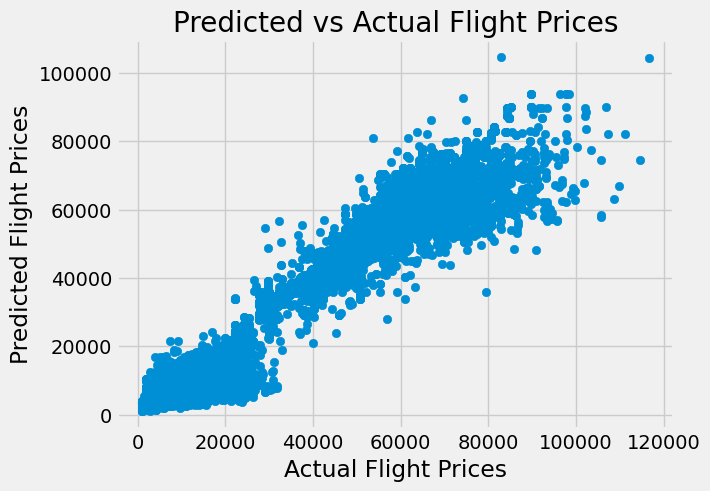

In [290]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Flight Prices')
plt.ylabel('Predicted Flight Prices')
plt.title('Predicted vs Actual Flight Prices')
plt.show()

We see that the graph looks more or less go in a linear direction.

In [291]:
# seeing the imporantance of each variable

importances = dict(zip(reg.feature_names_in_, reg.feature_importances_))
sorted_importances = sorted(importances.items(), key = lambda x: x[1], reverse = True)

sorted_importances

[('class', 0.8978490934892164),
 ('duration', 0.05769274966348409),
 ('airline_Vistara', 0.005809086383195064),
 ('airline_Air India', 0.004177502989721053),
 ('from_Delhi', 0.004062912422744548),
 ('to_Delhi', 0.0034989441491586155),
 ('stop', 0.002227723407654691),
 ('from_Mumbai', 0.002196373366335209),
 ('to_Kolkata', 0.0018938396802306984),
 ('to_Mumbai', 0.0018120220713577066),
 ('to_Hyderabad', 0.0016726393524601284),
 ('from_Hyderabad', 0.001663454599911488),
 ('from_Kolkata', 0.001622382091020667),
 ('dep_timeframe_Evening', 0.0014473630730854096),
 ('arr_timeframe_Early Morning', 0.0014328714255309556),
 ('arr_timeframe_Afternoon', 0.0013019897099271272),
 ('to_Bangalore', 0.0010673690516362247),
 ('from_Bangalore', 0.0010295481640103796),
 ('arr_timeframe_Night', 0.0009210728813832276),
 ('from_Chennai', 0.000873372653330981),
 ('to_Chennai', 0.0008046623660639971),
 ('arr_timeframe_Evening', 0.0007878364503696978),
 ('dep_timeframe_Morning', 0.000784727208398188),
 ('dep_ti

In [292]:
importance_df = pd.DataFrame(data = sorted_importances)

In [293]:
importance_df.head()

,0,1
0,class,0.8978
1,duration,0.0577
2,airline_Vistara,0.0058
3,airline_Air India,0.0042
4,from_Delhi,0.0041


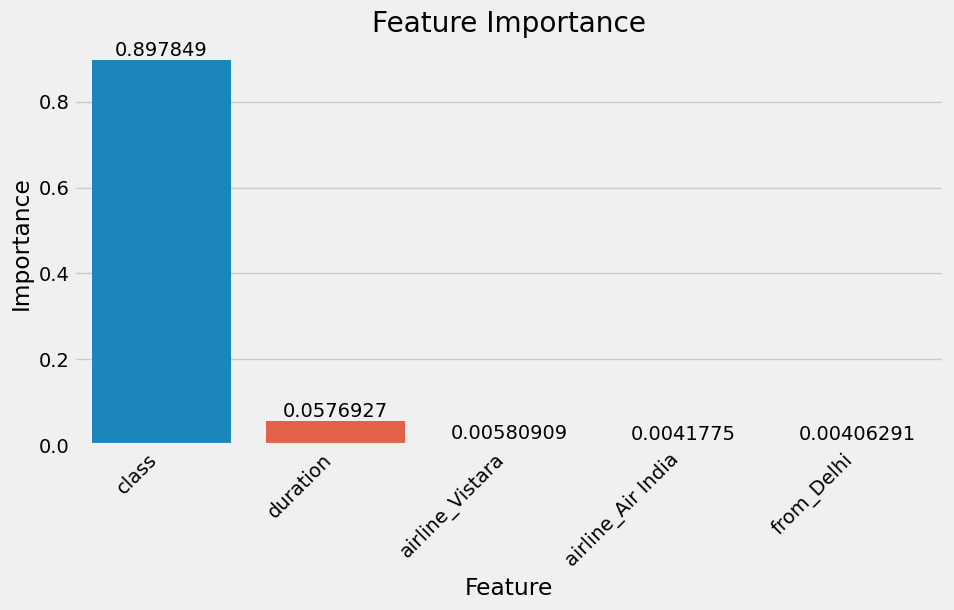

In [294]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data = importance_df.head(5), x = 0, y = 1)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation = 45, horizontalalignment = 'right')

for bars in ax.containers:
    ax.bar_label(bars)

plt.show()

We see that class is by far the most important factor in price which makes sense since business class is a lot more expensive than economy class. Duration looks to be the next most important factor which does make sense but it is way lower than I expected when comparing to class.

### Hyperparameter Tuning

I am tuning my model to see if it can produce better results. I will run through different variations of the model using different parameters to see if there are any improvements.

In [295]:
from sklearn.model_selection import GridSearchCV

### Full Grid Search

In [296]:
# reg = RandomForestRegressor(n_jobs = -1, random_state = 42)

In [297]:
param_grid = {
    'n_estimators': [100, 200, 300], # if the highest value is the best maybe can try higher numbers
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

In [298]:
# this will take a while (~20 minutes)

#grid_search = GridSearchCV(reg, param_grid, cv = 5)
#grid_search.fit(X_train, y_train)

In [299]:
#best_params = grid_search.best_params_

In [300]:
#best_params

**Best Parameters:**

{'max_depth': 30, \
 'max_features': 'sqrt', \
 'min_samples_leaf': 1, \
 'min_samples_split': 2, \
 'n_estimators': 300}

### n_estimator = 300

In [301]:
reg_300 = RandomForestRegressor(n_jobs = -1,
                            max_depth = 30,
                            max_features = 'sqrt',
                            min_samples_leaf = 1,
                            min_samples_split = 2,
                            n_estimators = 300,
                            random_state = 42
                            )

reg_300.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=300,
                      n_jobs=-1, random_state=42)

In [302]:
y_pred_300 = reg_300.predict(X_test)

In [303]:
r2_300 = r2_score(y_test, y_pred_300)
mae_300 = mean_absolute_error(y_test, y_pred_300)
mse_300 = mean_squared_error(y_test, y_pred_300)
rmse_300 = math.sqrt(mse_300)

print('R2', r2_300)
print('MAE', mae_300)
print('MSE', mse_300)
print('RMSE', rmse_300)

R2 0.9754384097696732
MAE 2159.819610543538
MSE 12639505.445879648
RMSE 3555.208214138751


In [304]:
importances_300 = dict(zip(reg_300.feature_names_in_, reg_300.feature_importances_))
sorted_importances_300 = sorted(importances_300.items(), key = lambda x: x[1], reverse = True)

sorted_importances_300

[('class', 0.7800578525333435),
 ('duration', 0.05181906909437035),
 ('airline_Vistara', 0.04440105696497463),
 ('airline_Indigo', 0.0254227253498802),
 ('stop', 0.019609454501221167),
 ('airline_GO FIRST', 0.013039034345208615),
 ('airline_Air India', 0.01191594364657363),
 ('airline_AirAsia', 0.009544999238544674),
 ('airline_SpiceJet', 0.003815625597167155),
 ('from_Delhi', 0.0027849703709967493),
 ('to_Delhi', 0.0024487606687453242),
 ('to_Mumbai', 0.0024483188365412426),
 ('from_Mumbai', 0.0022980562902227405),
 ('to_Kolkata', 0.002193848264609958),
 ('from_Kolkata', 0.002098599979224204),
 ('dep_timeframe_Evening', 0.0019901768380421055),
 ('to_Bangalore', 0.001876431262432511),
 ('to_Hyderabad', 0.001817008297714613),
 ('from_Hyderabad', 0.0017869227764684263),
 ('from_Bangalore', 0.0017600948002873026),
 ('arr_timeframe_Late Night', 0.0016372066563517028),
 ('dep_timeframe_Afternoon', 0.0015631393659639972),
 ('arr_timeframe_Early Morning', 0.0015403805630153586),
 ('arr_timefr

In [305]:
importance_df_300 = pd.DataFrame(data = sorted_importances_300)

In [306]:
importance_df_300.head()

,0,1
0,class,0.7801
1,duration,0.0518
2,airline_Vistara,0.0444
3,airline_Indigo,0.0254
4,stop,0.0196


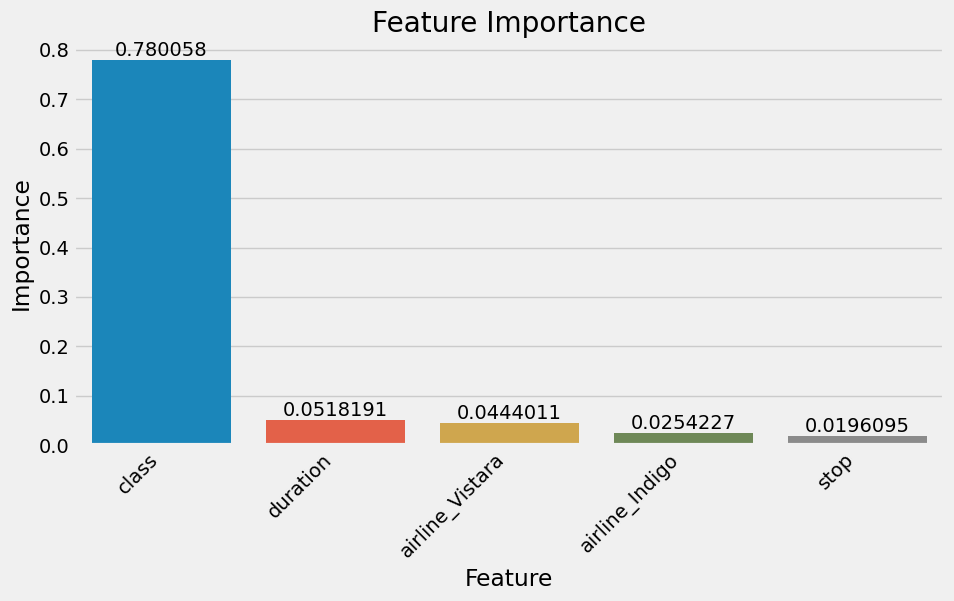

In [307]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data = importance_df_300.head(5), x = 0, y = 1)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation = 45, horizontalalignment = 'right')

for bars in ax.containers:
    ax.bar_label(bars)

plt.show()

### n_estimator = 500

Since the gridsearch's best parameters for the n_estimator was 300, I want to see if increasing that to 500 makes any difference.

In [308]:
reg_500 = RandomForestRegressor(n_jobs = -1,
                            max_depth = 30,
                            max_features = 'sqrt',
                            min_samples_leaf = 1,
                            min_samples_split = 2,
                            n_estimators = 500
                            )

reg_500.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=500,
                      n_jobs=-1)

In [309]:
y_pred_500 = reg_500.predict(X_test)

In [310]:
r2_500 = r2_score(y_test, y_pred_500)
mae_500 = mean_absolute_error(y_test, y_pred_500)
mse_500 = mean_squared_error(y_test, y_pred_500)
rmse_500 = math.sqrt(mse_500)

print('R2', r2_500)
print('MAE', mae_500)
print('MSE', mse_500)
print('RMSE', rmse_500)

R2 0.9754328292830137
MAE 2159.7910031654505
MSE 12642377.18956002
RMSE 3555.612069610522


In [311]:
importances_500 = dict(zip(reg_500.feature_names_in_, reg_500.feature_importances_))
sorted_importances_500 = sorted(importances_500.items(), key = lambda x: x[1], reverse = True)

sorted_importances_500

[('class', 0.7728927825502246),
 ('duration', 0.051304424751177774),
 ('airline_Vistara', 0.04790409223407415),
 ('airline_Indigo', 0.02636810023628293),
 ('stop', 0.019758239585505412),
 ('airline_Air India', 0.01420087582599636),
 ('airline_GO FIRST', 0.013422807548239062),
 ('airline_AirAsia', 0.009755796165205258),
 ('airline_SpiceJet', 0.004373248374104266),
 ('from_Delhi', 0.002842218348124159),
 ('to_Delhi', 0.0024458268021195087),
 ('to_Mumbai', 0.0024211668176031607),
 ('to_Kolkata', 0.0022511883832159883),
 ('from_Mumbai', 0.002205548296198841),
 ('from_Kolkata', 0.002070042746030293),
 ('dep_timeframe_Evening', 0.0019190379305814445),
 ('to_Bangalore', 0.0018387311837891316),
 ('to_Hyderabad', 0.0018201848236366945),
 ('from_Hyderabad', 0.0017968855657408173),
 ('from_Bangalore', 0.0017408041810963143),
 ('arr_timeframe_Late Night', 0.0016528488826179314),
 ('arr_timeframe_Early Morning', 0.0015837566124835732),
 ('arr_timeframe_Evening', 0.0015179139330260846),
 ('dep_timef

In [312]:
importance_df_500 = pd.DataFrame(data = sorted_importances_500)

In [313]:
importance_df_500.head()

,0,1
0,class,0.7729
1,duration,0.0513
2,airline_Vistara,0.0479
3,airline_Indigo,0.0264
4,stop,0.0198


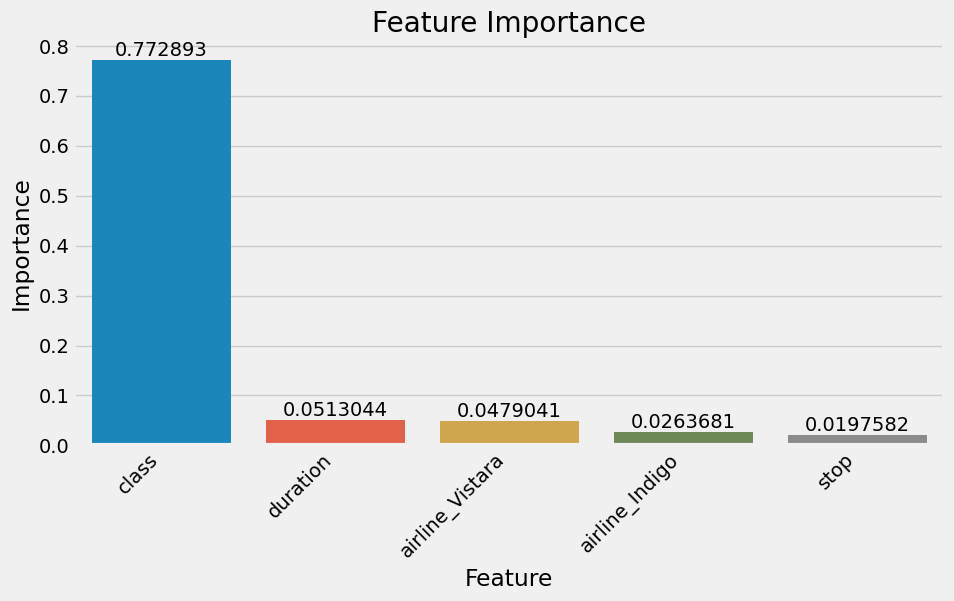

In [314]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data = importance_df_500.head(5), x = 0, y = 1)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation = 45, horizontalalignment = 'right')

for bars in ax.containers:
    ax.bar_label(bars)

plt.show()

### Random Search

In [315]:
# for when you don't have much time
# provide ranges and pick random values that work
# way less attempts

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [316]:
param_dist =  {
    'n_estimators': randint(100,500),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2,11),
    'min_samples_leaf': randint(1,5),
    'max_features': [1.0, 'auto', 'sqrt']
}

In [317]:
reg_rand = RandomForestRegressor(n_jobs = -1, random_state = 42)

In [318]:
random_search = RandomizedSearchCV(estimator = reg_rand, param_distributions = param_dist, n_iter = 2, cv = 3, # 2 iterations of 3 cv's = 6 attempts
                                   scoring = 'neg_mean_squared_error', verbose = 2, random_state = 42, n_jobs = -1)

In [319]:
# ~1 minute vs ~20 from doing a full gridsearch

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': [1.0, 'auto', 'sqrt'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000245B9C4AFD0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000245BAA5F690>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024695183990>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [320]:
best_regressor = random_search.best_estimator_

In [321]:
y_pred_random = best_regressor.predict(X_test)

r2_random = r2_score(y_test, y_pred_random)
mae_random = mean_absolute_error(y_test, y_pred_random)
mse_random = mean_squared_error(y_test, y_pred_random)
rmse_random = math.sqrt(mse_random)

print('R2', r2_random)
print('MAE', mae_random)
print('MSE', mse_random)
print('RMSE', rmse_random)

R2 0.9750200270954463
MAE 2211.987938968098
MSE 12854807.062744115
RMSE 3585.3601022413513


In [322]:
importances_rand = dict(zip(best_regressor.feature_names_in_, best_regressor.feature_importances_))
sorted_importances_rand = sorted(importances_rand.items(), key = lambda x: x[1], reverse = True)

sorted_importances_rand

[('class', 0.8992824354418298),
 ('duration', 0.056730223931158376),
 ('airline_Air India', 0.005151858637751967),
 ('airline_Vistara', 0.004840019399076697),
 ('from_Delhi', 0.004014608543304175),
 ('to_Delhi', 0.003466769965368832),
 ('stop', 0.0022109001215354857),
 ('from_Mumbai', 0.002196589171379314),
 ('to_Kolkata', 0.0019137708975364347),
 ('to_Mumbai', 0.0018037529984239514),
 ('from_Hyderabad', 0.001649827790082058),
 ('to_Hyderabad', 0.001642549753916289),
 ('from_Kolkata', 0.0016292837190067975),
 ('arr_timeframe_Early Morning', 0.0014188972839414464),
 ('dep_timeframe_Evening', 0.0014139722937805646),
 ('arr_timeframe_Afternoon', 0.0012930536452264625),
 ('to_Bangalore', 0.0010812626383312574),
 ('from_Bangalore', 0.0010061219862143715),
 ('arr_timeframe_Night', 0.0008760016757543486),
 ('from_Chennai', 0.0008505591139524535),
 ('dep_timeframe_Morning', 0.0007611867414386962),
 ('to_Chennai', 0.0007554412192406202),
 ('arr_timeframe_Evening', 0.0007507870513184646),
 ('dep

In [323]:
importance_df_rand = pd.DataFrame(data = sorted_importances_rand)

In [324]:
importance_df_rand.head()

,0,1
0,class,0.8993
1,duration,0.0567
2,airline_Air India,0.0052
3,airline_Vistara,0.0048
4,from_Delhi,0.0040


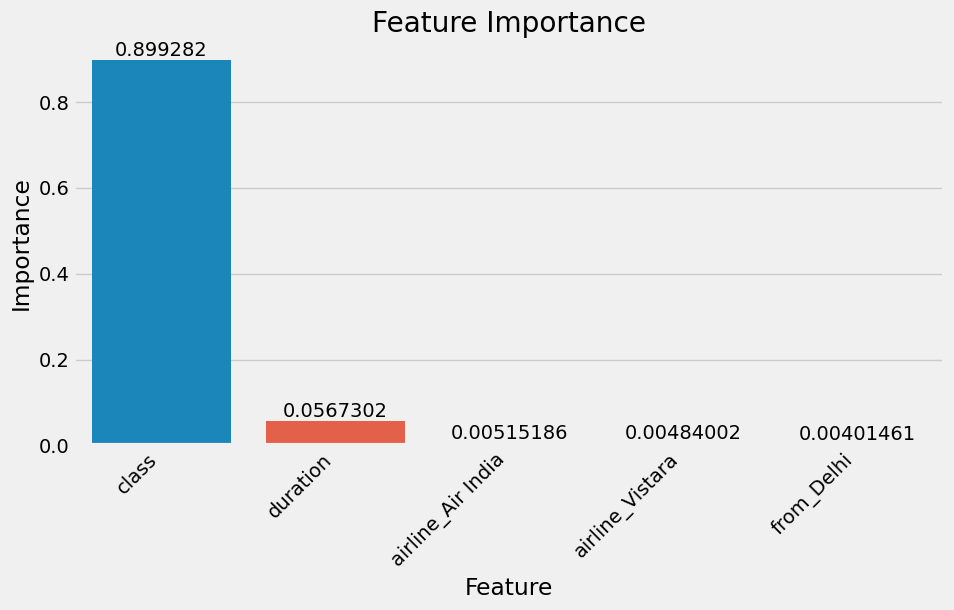

In [325]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data = importance_df_rand.head(5), x = 0, y = 1)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation = 45, horizontalalignment = 'right')

for bars in ax.containers:
    ax.bar_label(bars)

plt.show()

### Results

In [326]:
results_dict = {'Metrics': ['R2','MAE','MSE','RMSE'],
                'Original': [r2_0, mae_0, mse_0, rmse_0],
                'n_est_300': [r2_300, mae_300, mse_300, rmse_300],
                'n_est_500': [r2_500, mae_500, mse_500, rmse_500],
                'Random_Search': [r2_random, mae_random, mse_random, rmse_random]
                }

df_results = pd.DataFrame(data = results_dict)

In [327]:
pd.options.display.float_format = '{:.4f}'.format

In [328]:
df_results

,Metrics,Original,n_est_300,n_est_500,Random_Search
0,R2,0.9755,0.9754,0.9754,0.9750
1,MAE,2156.2325,2159.8196,2159.7910,2211.9879
2,MSE,12588472.0641,12639505.4459,12642377.1896,12854807.0627
3,RMSE,3548.0237,3555.2082,3555.6121,3585.3601


Looking at the results of the different variances of the model, we see that there isn't much of an overall difference in the results though the random search does have the worst results overall. The mean squared errors look to be the most different but that is likely due to how large the number is to begin with. Other than that the other results don't differ much.

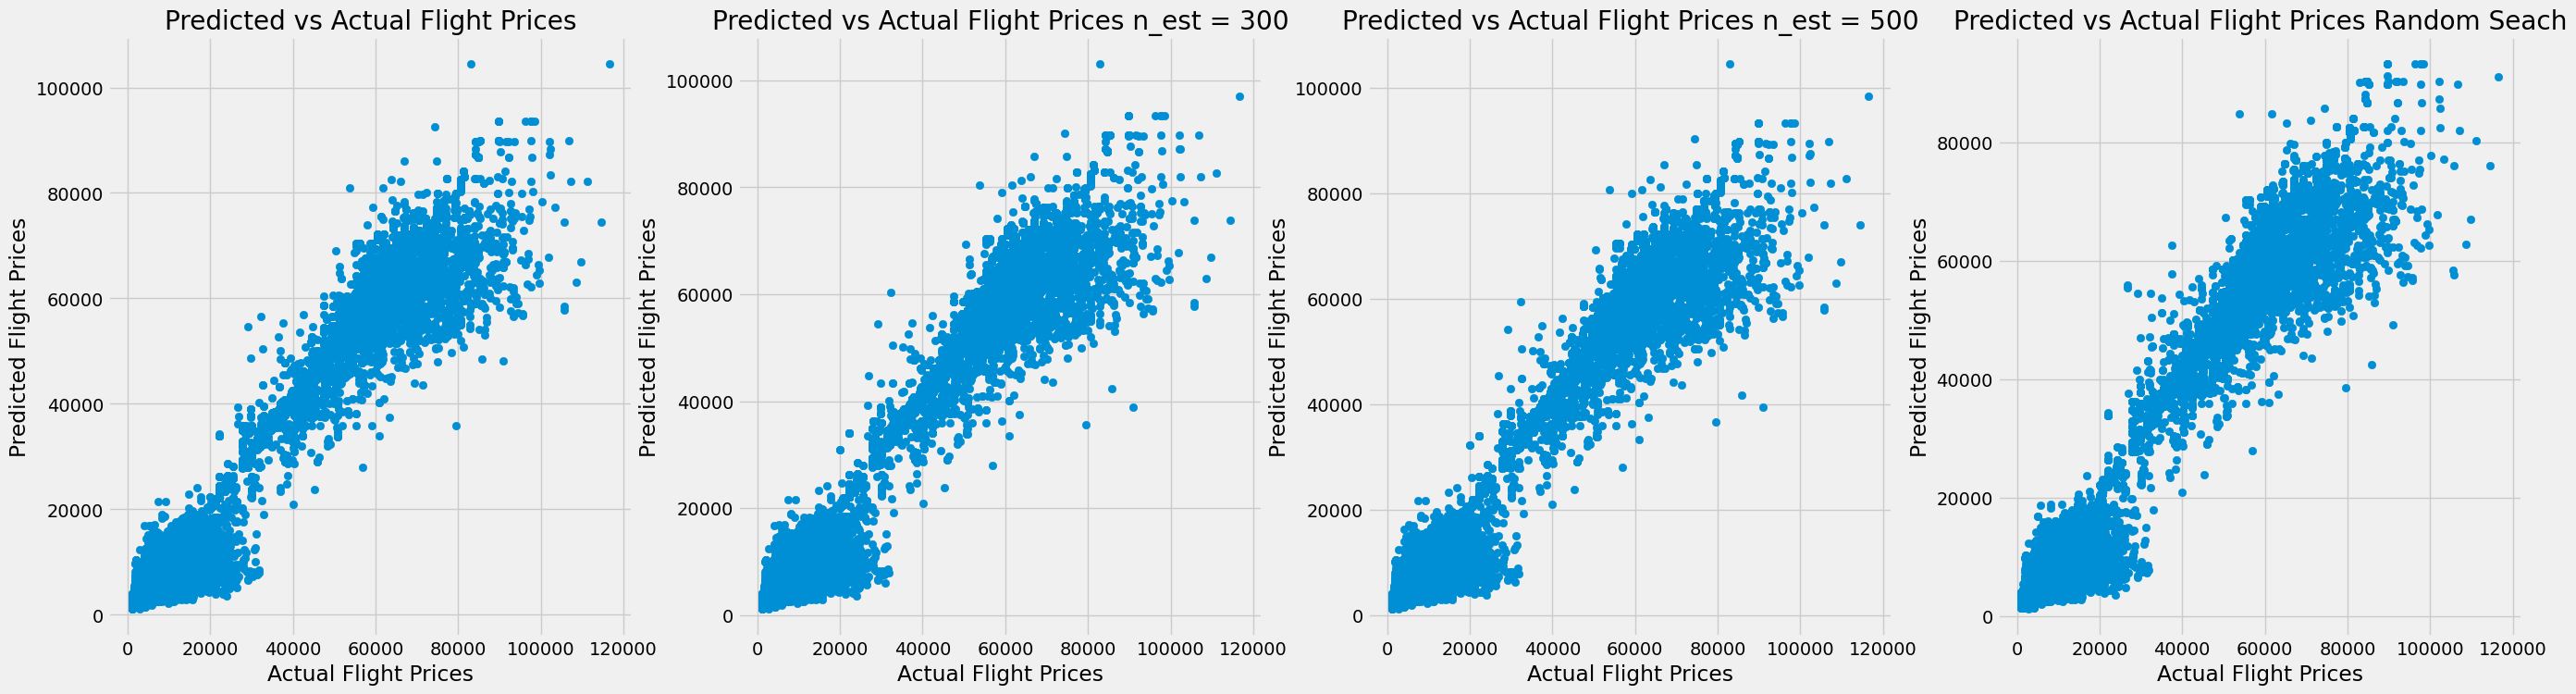

In [329]:
figure, axes = plt.subplots(1,4, figsize = (30,8))

axes[0].scatter(y_test, y_pred)
axes[0].set_title('Predicted vs Actual Flight Prices')
axes[0].set_xlabel('Actual Flight Prices')
axes[0].set_ylabel('Predicted Flight Prices')


axes[1].scatter(y_test, y_pred_300)
axes[1].set_title('Predicted vs Actual Flight Prices n_est = 300')
axes[1].set_xlabel('Actual Flight Prices')
axes[1].set_ylabel('Predicted Flight Prices')

axes[2].scatter(y_test, y_pred_500)
axes[2].set_title('Predicted vs Actual Flight Prices n_est = 500')
axes[2].set_xlabel('Actual Flight Prices')
axes[2].set_ylabel('Predicted Flight Prices')


axes[3].scatter(y_test, y_pred_random)
axes[3].set_title('Predicted vs Actual Flight Prices Random Seach')
axes[3].set_xlabel('Actual Flight Prices')
axes[3].set_ylabel('Predicted Flight Prices')

plt.show()

They all look visually similar as well.

In [330]:
importance_df.columns = ['Feature', 'Original']
importance_df_300.columns = ['Feature', 'n_est_300']
importance_df_500.columns = ['Feature', 'n_est_500']
importance_df_rand.columns = ['Feature', 'Random_search']

In [331]:
importance_join = pd.merge(importance_df, importance_df_300, on = 'Feature', how = 'left')
importance_join = pd.merge(importance_join, importance_df_500, on = 'Feature', how = 'left')
importance_join = pd.merge(importance_join, importance_df_rand, on = 'Feature', how = 'left')

In [332]:
importance_join.head()

,Feature,Original,n_est_300,n_est_500,Random_search
0,class,0.8978,0.7801,0.7729,0.8993
1,duration,0.0577,0.0518,0.0513,0.0567
2,airline_Vistara,0.0058,0.0444,0.0479,0.0048
3,airline_Air India,0.0042,0.0119,0.0142,0.0052
4,from_Delhi,0.0041,0.0028,0.0028,0.0040


In [333]:
# Top 5 importance for the original model
importance_join.sort_values(['Original'], ascending = False).head()

,Feature,Original,n_est_300,n_est_500,Random_search
0,class,0.8978,0.7801,0.7729,0.8993
1,duration,0.0577,0.0518,0.0513,0.0567
2,airline_Vistara,0.0058,0.0444,0.0479,0.0048
3,airline_Air India,0.0042,0.0119,0.0142,0.0052
4,from_Delhi,0.0041,0.0028,0.0028,0.0040


In [334]:
# Top 5 importance for the model where n_estimators are 300
importance_join.sort_values(['n_est_300'], ascending = False).head()

,Feature,Original,n_est_300,n_est_500,Random_search
0,class,0.8978,0.7801,0.7729,0.8993
1,duration,0.0577,0.0518,0.0513,0.0567
2,airline_Vistara,0.0058,0.0444,0.0479,0.0048
30,airline_Indigo,0.0001,0.0254,0.0264,0.0001
6,stop,0.0022,0.0196,0.0198,0.0022


In [335]:
# Top 5 importance for the model where n_estimators are 500
importance_join.sort_values(['n_est_500'], ascending = False).head()

,Feature,Original,n_est_300,n_est_500,Random_search
0,class,0.8978,0.7801,0.7729,0.8993
1,duration,0.0577,0.0518,0.0513,0.0567
2,airline_Vistara,0.0058,0.0444,0.0479,0.0048
30,airline_Indigo,0.0001,0.0254,0.0264,0.0001
6,stop,0.0022,0.0196,0.0198,0.0022


In [336]:
# Top 5 importance for the model where we did a random search
importance_join.sort_values(['Random_search'], ascending = False).head()

,Feature,Original,n_est_300,n_est_500,Random_search
0,class,0.8978,0.7801,0.7729,0.8993
1,duration,0.0577,0.0518,0.0513,0.0567
3,airline_Air India,0.0042,0.0119,0.0142,0.0052
2,airline_Vistara,0.0058,0.0444,0.0479,0.0048
4,from_Delhi,0.0041,0.0028,0.0028,0.0040


We see that class has by far the highest importance for all the models we ran with duration being the next important. We see that the importance for n_est_300 and 500 are the same with very similar results. This leads me to believe that increasing the n_estimator to 500 didn't really make much of a difference in the overall restuls. The orginal model and the random search model are very similar with having the same top 5 feature importance except for the swap in the Air India and Vistara.

In [337]:
df_results

,Metrics,Original,n_est_300,n_est_500,Random_Search
0,R2,0.9755,0.9754,0.9754,0.9750
1,MAE,2156.2325,2159.8196,2159.7910,2211.9879
2,MSE,12588472.0641,12639505.4459,12642377.1896,12854807.0627
3,RMSE,3548.0237,3555.2082,3555.6121,3585.3601


Adding hyperparamters to my model made very slight improvements in my model.